# MIT-BIH-AFIB-03-datasets.ipynb
Notebook used to create TFRecord datasets from the MIT-BIH Atrial Fibrillation Database.   
See https://physionet.org/content/afdb/1.0.0/  

In [1]:
# Environment setup.
import os
import re
import sys
import platform
import tensorflow as tf
import numpy as np
from scipy import stats

import fileutils as fu
import mit_bih_afib_db as db
import mit_bih_afib_tfrecord as tfr
import wfdb_utils as wfu

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os_name = platform.system()
print('OS name:            {} {}'.format(os_name, platform.release()))
print('Python version:     {}.{}.{}'.format(sys.version_info[0], sys.version_info[1], sys.version_info[2]))
print('TensorFlow version: {}'.format(tf.__version__))
print('Numpy version:      {}'.format(np.__version__))
print('You are here: {}'.format(os.getcwd()))

OS name:            Windows 10
Python version:     3.10.10
TensorFlow version: 2.10.0
Numpy version:      1.23.2
You are here: D:\dev\jupyter\deep-cnn-embedded\src\mit-bih-afib


In [2]:
db.LOCAL_DATA_PATH = r'E:\Data\MIT-BIH-AFIB\files'
db.LOCAL_TFRECORD_PATH = r'E:\Data\MIT-BIH-AFIB\tfrecord'
ECG_CHANNEL = 0

In [3]:
import FirFilter1D as fir
flt = fir.FirFilter1D()
flt.load_coeffs_file('BPF-Coeffs.txt')
filt_len = flt.coeff_len()
print('FIR filter length: {}'.format(filt_len))

FIR filter length: 741


In [4]:
# Function to convert a WFDB ECG data file to a TFRecord data file.
# Returns 1 if TFRecord file created, 0 otherwise.
def wfdb_to_tfrecord(src, pid, rtype, start, length, fir_filter):
    start = int(start)
    length = int(length)
    # Get the TFRecord file name.
    tf_path, tf_file = db.get_tfrecord_filename(pid, rtype, start, length)
    fu.mkpath(tf_path) # Create paths if needed
    
    # Get the WFDB ECG header.
    ecg_hdr = wfu.read_header(src)
    max_samp = ecg_hdr.sig_len - 1
    
    # Get FIR filter start, length, and pad parameters.
    coeff_len = fir_filter.coeff_len()
    crop_len = int(coeff_len / 2)
    if (start >= crop_len):
        fir_start = start - crop_len
        fir_length = length + crop_len
        fir_start_pad = 0
    else:
        fir_start = 0
        fir_length = length + start
        fir_start_pad = crop_len - start
    end = start + length
    if ((end + crop_len) <= max_samp):
        fir_length += crop_len
        fir_end_pad = 0
    else:
        fir_length += (max_samp - end)
        fir_end_pad = end + crop_len - max_samp
    #print(fir_start, fir_start_pad, fir_length, fir_end_pad)
    
    # Create a one-hot vector for the label.
    lnum = db.LABELS[str(rtype).upper()]
    one_hot = np.zeros(len(db.LABELS))
    one_hot[lnum] = 1.
    
    # Get the raw WFDB ECG record.
    ecg_raw_rec = wfu.read_data(src, start=start, length=length)
    ecg_raw = ecg_raw_rec.p_signal[:,ECG_CHANNEL].flatten().astype(np.float32)
    
    # Get the filtered ECG record.
    ecg_fir_rec = wfu.read_data(src, start=fir_start, length=fir_length)
    ecg_fir = ecg_fir_rec.p_signal[:,ECG_CHANNEL].flatten().astype(np.float32)
    ecg_fir = np.append(np.zeros(fir_start_pad), ecg_fir)
    ecg_fir = np.append(ecg_fir, np.zeros(fir_end_pad))
    ecg_fir = fir_filter.filter(ecg_fir)
    
    # Compute Z-Norms of each.
    ecg_raw_z = stats.zscore(ecg_raw)
    ecg_fir_z = stats.zscore(ecg_fir)
    
    # Perform error checks.
    iserror = False
    raw_sum = np.sum(ecg_raw)
    raw_z_sum = np.sum(ecg_raw_z)
    fir_sum = np.sum(ecg_fir)
    fir_z_sum = np.sum(ecg_fir_z)
    if (ecg_fir.size != length):
        iserror = True
        errmsg = 'FIR length error ({})'.format(ecg_fir.size)
    elif np.isinf(raw_sum):
        iserror = True
        errmsg = 'raw contains +/- inf'
    elif np.isnan(raw_sum):
        iserror = True
        errmsg = 'raw contains NaN'
    elif np.isinf(raw_z_sum):
        iserror = True
        errmsg = 'raw Z-Norm contains +/- inf'
    elif np.isnan(raw_z_sum):
        iserror = True
        errmsg = 'raw Z-Norm contains NaN'
    elif np.isinf(fir_sum):
        iserror = True
        errmsg = 'FIR contains +/- inf'
    elif np.isnan(fir_sum):
        iserror = True
        errmsg = 'FIR contains NaN'
    elif np.isinf(fir_z_sum):
        iserror = True
        errmsg = 'FIR Z-Norm contains +/- inf'
    elif np.isnan(fir_z_sum):
        iserror = True
        errmsg = 'FIR Z-Norm contains NaN'
    if iserror:
        print('ECG {}, {} not created.'.format(errmsg, tf_file))
        print('Source: {}'.format(src))
        return 0
    
    # Create the map of data to feature proto objects.
    feature = {}
    feature['ecg_raw'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_raw))
    feature['ecg_fir'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_fir))
    feature['ecg_raw_z'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_raw_z))
    feature['ecg_fir_z'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_fir_z))
    feature['one_hot'] = tf.train.Feature(float_list=tf.train.FloatList(value=one_hot))
    
    # Construct the Example proto object.
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize the example to a string.
    serialized = example.SerializeToString()

    # Write the serialized object to the disk
    with tf.io.TFRecordWriter(tf_file) as writer:
        writer.write(serialized)
    return 1

### Create one TFRecord

In [5]:
seq_file = db.get_sequences_file('AFIB')
fd = fu.open_file(seq_file)
(pid, rtype, start, length) = fd.readline().strip().split(',')
fu.close_file(fd)
tfr_path, tfr_file = db.get_tfrecord_filename(pid, rtype, start, length)
wfdb_src = db.get_wfdb_path(pid)
print('Creating {}'.format(tfr_file))
print('Source:  {}'.format(wfdb_src))
count = wfdb_to_tfrecord(wfdb_src, pid, rtype, start, length, flt)
if (count == 1): print('Success')
else: print('Failed')

Creating E:\Data\MIT-BIH-AFIB\tfrecord\04015\04015_AFIB_0102584_0007500.tfrecord
Source:  E:\Data\MIT-BIH-AFIB\files\04015
Success


### Read it back and plot the data

In [6]:
tfr.ECG_LENGTH = int(length)
ds = tf.data.TFRecordDataset([tfr_file])
ds = ds.map(tfr.ecg_map_all)
for dr in ds.take(1):
    pass
ecg_raw   = dr[0]
ecg_fir   = dr[1]
ecg_raw_z = dr[2]
ecg_fir_z = dr[3]
one_hot   = dr[4]
print('One-Hot: {}'.format(one_hot))

One-Hot: [0. 0. 0. 1. 0.]


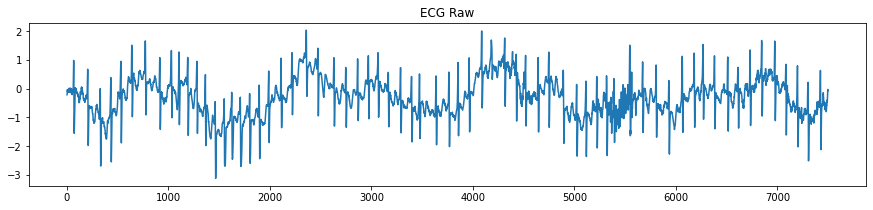

Samples: 7500
Mean:    -0.3114
Stdev:   0.6664


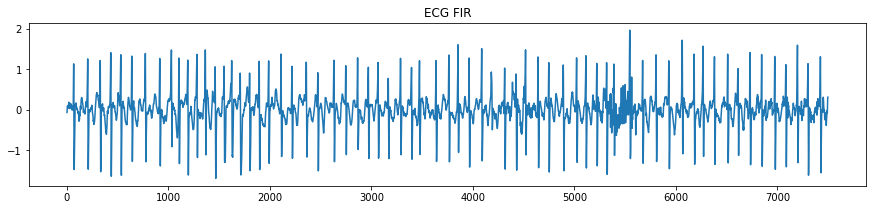

Samples: 7500
Mean:    -0.0026
Stdev:   0.3906


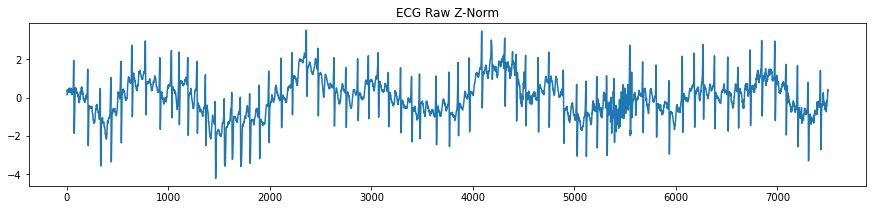

Samples: 7500
Mean:    0.0000
Stdev:   1.0000


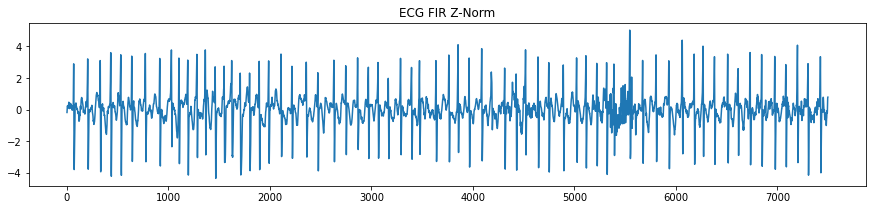

Samples: 7500
Mean:    0.0000
Stdev:   1.0000


In [7]:
plt.figure(figsize=(15, 3))
plt.plot(ecg_raw)
plt.title('ECG Raw')
plt.show()
print('Samples: {}'.format(len(ecg_raw)))
print('Mean:    {:0.4f}'.format(np.mean(ecg_raw)))
print('Stdev:   {:0.4f}'.format(np.std(ecg_raw)))

plt.figure(figsize=(15, 3))
plt.plot(ecg_fir)
plt.title('ECG FIR')
plt.show()
print('Samples: {}'.format(len(ecg_fir)))
print('Mean:    {:0.4f}'.format(np.mean(ecg_fir)))
print('Stdev:   {:0.4f}'.format(np.std(ecg_fir)))

plt.figure(figsize=(15, 3))
plt.plot(ecg_raw_z)
plt.title('ECG Raw Z-Norm')
plt.show()
print('Samples: {}'.format(len(ecg_raw_z)))
print('Mean:    {:0.4f}'.format(np.mean(ecg_raw_z)))
print('Stdev:   {:0.4f}'.format(np.std(ecg_raw_z)))

plt.figure(figsize=(15, 3))
plt.plot(ecg_fir_z)
plt.title('ECG FIR Z-Norm')
plt.show()
print('Samples: {}'.format(len(ecg_fir_z)))
print('Mean:    {:0.4f}'.format(np.mean(ecg_fir_z)))
print('Stdev:   {:0.4f}'.format(np.std(ecg_fir_z)))

### Run this cell to create TFRecord files  
Set batch_size to the maximum number of TFRecord files to create. 

In [10]:
batch_size = 10000
tfrecord_count = 0
print('{} TFRecord start.'.format(db.timestamp()))

for rtype in db.RTYPES:
    if (tfrecord_count >= batch_size):
        break
    seq_file = db.get_sequences_file(rtype)
    seq_fd = fu.open_file(seq_file)
    for line in seq_fd:
        (pid, _, start, length) = line.strip().split(',')
        wfdb_path = db.get_wfdb_path(pid)
        tfr_path, tfr_file = db.get_tfrecord_filename(pid, rtype, start, length)
        if not os.path.isfile(tfr_file):
            tfrecord_count += wfdb_to_tfrecord(wfdb_path, pid, rtype, start, length, flt)
        if (tfrecord_count >= batch_size):
            fu.close_file(seq_fd)
            break
    fu.close_file(seq_fd)

print('{} TFRecord complete.'.format(db.timestamp()))
print('{} TFRecord files created.'.format(tfrecord_count))

2023-07-03 18:43:44 TFRecord start.
2023-07-03 18:50:36 TFRecord complete.
6610 TFRecord files created.


### Run this cell to count the number of TFRecord files

In [8]:
tfrecord_count = 0
tfrecord_file_pat = re.compile(db.TFRECORD_FILE_RE)
for (dirpath, dirs, files) in os.walk(db.LOCAL_TFRECORD_PATH):
    for file in files:
        if tfrecord_file_pat.match(file):
            tfrecord_count += 1
print('Total TFRecords: {}'.format(tfrecord_count))

Total TFRecords: 27814


### Create train, test, and validation lists  

In [9]:
class_list = ['N', 'AFIB']
train_list, test_list, val_list = tfr.create_tfrecord_lists(
    class_list,
    test_split=0.05,
    val_split=0.05,
    max_records=11064,
    seed=12345
)

train_size = len(train_list)
test_size = len(test_list)
val_size = len(val_list)

print('Train size:      {}'.format(train_size))
print('Test size:       {}'.format(test_size))
print('Validation size: {}'.format(val_size))

if (train_size > 0): print(train_list[0])
if (test_size > 0): print(test_list[0])
if (val_size > 0): print(val_list[0])

Train size:      9956
Test size:       554
Validation size: 554
E:\Data\MIT-BIH-AFIB\tfrecord\04015\04015_N_0000030_0007500.tfrecord
E:\Data\MIT-BIH-AFIB\tfrecord\07910\07910_N_1217393_0007500.tfrecord
E:\Data\MIT-BIH-AFIB\tfrecord\04936\04936_AFIB_3863166_0007500.tfrecord


### Analyze the file lists to ensure an even distribution of rhythm types   

In [10]:
def analyze_list(file_list):
    tfrecord_file_pat = re.compile(db.TFRECORD_FILE_RE)
    
    # Initialize arrays.
    class_array = {}    
    for rtype in class_list:
        pid_array = {}
        for pid in db.PATIENT_IDS:
            pid_array[pid] = 0          # One count per PID
        class_array[rtype] = pid_array  # One PID array per class

    # Count examples per PID per class.
    for file in file_list:
        if not os.path.isfile(file):
            print('File does not exist: {}'.format(file))
        m = tfrecord_file_pat.search(file)
        if m:
            pid = m.group(1)
            rtype = m.group(2)
            class_array[rtype][pid] += 1  # Increment for this class and PID
    
    # Summarize per class.
    for rtype in class_list:
        class_summary = {'PIDS':0, 'EXAMPLES':0}
        pid_array = class_array[rtype]
        for pid in pid_array:
            if (pid_array[pid] > 0):
                class_summary['PIDS'] += 1
                class_summary['EXAMPLES'] += pid_array[pid]
        print('{:>4s}: PIDs: {:>2d} Examples: {:>5d}'.format(rtype, class_summary['PIDS'], class_summary['EXAMPLES']))

In [11]:
print('Training list:')
analyze_list(train_list)
print('\nTest list:')
analyze_list(test_list)
print('\nValidation list:')
analyze_list(val_list)

Training list:
   N: PIDs: 21 Examples:  4978
AFIB: PIDs: 23 Examples:  4978

Test list:
   N: PIDs: 21 Examples:   277
AFIB: PIDs: 19 Examples:   277

Validation list:
   N: PIDs: 21 Examples:   277
AFIB: PIDs: 17 Examples:   277


### Create a tarfile of the TFRecords in the train, test and validation lists  
The tarfile can be used to transfer TFRecords to a ML workstation or cloud instance.  
Note that this can also take a long time to run and create a very large file.

In [11]:
# Make file paths relative to the tfrecord directory.
file = train_list[0]
idx = file.find('tfrecord')
root = file[:idx]

for listfile in [train_list, test_list, val_list]:
    for i in range(len(listfile)):
        file = listfile[i].replace('\\', '/')  # Truncate path and replace Windows separator with POSIX separator
        listfile[i] = file[idx:]

# Create CSV files of the tfrecord lists.
train_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_train_list.csv')
test_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_test_list.csv')
val_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_val_list.csv')
fu.create_file_from_list(train_file, train_list)
fu.create_file_from_list(test_file, test_list)
fu.create_file_from_list(val_file, val_list)
train_file = train_file.replace('\\', '/')[idx:]  # Truncate path and replace Windows separator with POSIX separator
test_file = test_file.replace('\\', '/')[idx:]
val_file = val_file.replace('\\', '/')[idx:]

# Create the tar file and add the TFRecord files.
cwd = os.getcwd()
os.chdir(root)
tarfile = os.path.join(db.LOCAL_TFRECORD_PATH, 'list_tfrecords.tar')
print('{} Creating tar file.'.format(db.timestamp()))
file_count = fu.mktar(tarfile, train_list, test_list, val_list, progress=1000)
file_count += fu.addtar(tarfile, [train_file, test_file, val_file])
print('{} Tar file complete.'.format(db.timestamp()))
print('Total files: {}'.format(file_count))
os.chdir(cwd)

2023-08-08 22:50:50 Creating tar file.
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 22128
2023-08-08 22:57:18 Tar file complete.
Total files: 22131
